# Price Prediction Using Linear Regression, Decision Trees, Random Forest, XGBoost, and Deep Neural Networks

This Jupyter notebook utilizes a preprocessed Used Cars dataset to explore various regression models for predicting prices, including Linear Regression, Decision Trees, Random Forests, eXtreme Gradient Boosting (XGBoost), and Deep Neural Networks (DNN). Additionally, it employs GridSearchCV and Hyperband (Keras Tuner) to fine-tune model parameters for optimal performance. The performance of each model is evaluated based on Root Mean Squared Error (RMSE).

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from xgboost import XGBRegressor
import tensorflow as tf
import keras_tuner as kt
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

## Data Prep 

Load the preprocessed Used Cars dataset 

In [2]:
df = pd.read_csv('filtered_used_cars_data.csv')

In [3]:
df.shape # the dimensions of the dataset

(977550, 11)

Define the features and target variable

In [4]:
X = df.drop('price', axis=1) # features
y = df['price'] # target variable

Split the dataset into training and testing sets.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Models

### 1) Linear Regression

In [6]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_test)
mse_linear = mean_squared_error(y_test, y_pred_linear)
rmse_linear = np.sqrt(mse_linear)
print("RMSE (Linear Regression):", rmse_linear)

RMSE (Linear Regression): 0.0039349203424231165


### 2) Decision Trees

In [7]:
param_grid_tree = {
    'max_depth': [10, 20, 30], # the maximum depth of the tree
    'min_samples_split': [2, 10], # the minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 5], # the minimum number of samples required to be at a leaf node
    'max_features': ['sqrt', 'log2', None]  # the number of features to consider when looking for the best split
}

model_dt = DecisionTreeRegressor()

grid_search_dt = GridSearchCV(estimator=model_dt, param_grid=param_grid_tree, cv=5, scoring='neg_mean_squared_error', verbose=1)

grid_search_dt.fit(X_train, y_train)

print("Best Parameters:", grid_search_dt.best_params_)
best_model_tree = grid_search_dt.best_estimator_

y_pred_dt = best_model_tree.predict(X_test)

mse_dt = mean_squared_error(y_test, y_pred_dt)
rmse_dt = np.sqrt(mse_dt)
print("RMSE (Decision Tree):", rmse_dt)


Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters: {'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 2}
RMSE (Decision Tree): 0.0028168047781605104


### 3) Random Forests

The implementation of a grid search for the Random Forest was omitted due to its time-consuming nature. Consequently, the optimal parameters identified from the Decision Tree model were utilized in configuring the Random Forest model. 

In [8]:
best_params_dt = grid_search_dt.best_params_


model_RF = RandomForestRegressor(
    max_depth=best_params_dt['max_depth'], # the maximum depth of the tree.
    min_samples_split=best_params_dt['min_samples_split'], # the minimum number of samples required to split an internal node
    min_samples_leaf=best_params_dt['min_samples_leaf'],  # the minimum number of samples required to be at a leaf node
    max_features=best_params_dt['max_features'], # the number of features to consider when looking for the best split:
    n_estimators=100 # the number of trees (default setting)
)

model_RF.fit(X_train, y_train.ravel())
y_pred_rf = model_RF.predict(X_test)
mse_rf = mean_squared_error(y_test.ravel(), y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
print("RMSE (Random Forest):", rmse_rf)

RMSE (Random Forest): 0.0026457892283568373


### 4) XGBoost (eXtreme Gradient Boosting)

In [59]:
param_grid_xgb = {
    'max_depth': [3, 5, 7], # the maximum tree depth for base learners
    'learning_rate': [0.01, 0.1], # boosting learning rate
    'subsample': [0.8, 1.0], # subsample ratio of the training instance
    'colsample_bytree': [0.8, 1.0], # subsample ratio of columns when constructing each tree.
    'reg_lambda': [0.01, 0.1, 1, 10] # L2 regularization term on weights. Increasing this value will make model more conservative.
}

model_xgb = XGBRegressor(n_estimators = 100)
grid_search_xgb = GridSearchCV(estimator=model_xgb, param_grid=param_grid_xgb, scoring='neg_mean_squared_error', cv=5, verbose=1)

grid_search_xgb.fit(X_train, y_train)

print("Best Parameters:", grid_search_xgb.best_params_)
best_model_xgb = grid_search_xgb.best_estimator_

y_pred_xgb = best_model_xgb.predict(X_test)

mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
print("RMSE (XGBoost):", rmse_xgb)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 7, 'reg_lambda': 10, 'subsample': 0.8}
RMSE (XGBoost): 0.0027845734602668913


### 5) Deep Neural Network

In [27]:
# model
def build_nn(hp):
    model_nn = tf.keras.Sequential()

    model_nn.add(tf.keras.layers.InputLayer(input_shape = X_train.shape[1])) # input layer
    model_nn.add(tf.keras.layers.Dense(units = hp.Int('units_1', min_value = 64, max_value = 256, step = 64), activation = 'relu')) #hidden layer 1
    model_nn.add(tf.keras.layers.Dense(units = hp.Int('units_2', min_value = 32, max_value = 128, step = 32), activation = 'relu')) #hidden layer 2
    model_nn.add(tf.keras.layers.Dense(units = hp.Int('units_3', min_value = 16, max_value = 64,  step = 16), activation = 'relu')) #hidden layer 3
    model_nn.add(tf.keras.layers.Dropout(hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))
    model_nn.add(tf.keras.layers.Dense(1)) # output layer

    model_nn.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=hp.Float('learning_rate',  min_value=1e-5, max_value=1e-2, sampling='LOG')),
                     loss='mean_squared_error')

    return model_nn

I applied Hyperband for tuning the parameters of the Deep Neural Network (DNN) model due to its efficiency in optimizing hyperparameters. Unlike traditional grid search method, which evaluate all combinations exhaustively, Hyperband employs a more resource-efficient approach by leveraging adaptive resource allocation and early stopping. This means that it can quickly discard poorly performing configurations while allocating more resources to the promising ones.

In [28]:
# Hyperband
tuner = kt.Hyperband(
    build_nn,
    objective='val_loss',  
    max_epochs=30,        
    factor=3,              
    directory='my_dir',    
    project_name='usedcars_nn'  
)

tuner.search(X_train, y_train, epochs=30, validation_split=0.2)

Trial 90 Complete [00h 04m 31s]
val_loss: 2.8404980184859596e-05

Best val_loss So Far: 7.011720754235284e-06
Total elapsed time: 01h 27m 51s


In [66]:
best_model_nn = tuner.get_best_models(num_models=1)[0]
best_params_nn = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best model summary:")
best_model_nn.summary()


Best model summary:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                704       
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 17,345
Trainable params: 17,345
Non-trainable params: 0
_________________________________________________________________


In [67]:
print("\nBest Hyperparameters:")
for hp in best_params_nn.values.items():
    name, value = hp
    print(f"{name}: {value}")


Best Hyperparameters:
units_1: 64
units_2: 128
units_3: 64
dropout: 0.0
learning_rate: 0.00021686067491772116
tuner/epochs: 30
tuner/initial_epoch: 10
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0068


In [38]:
best_model_nn.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
y_pred = best_model_nn.predict(X_test)
mse_nn = mean_squared_error(y_test, y_pred)
rmse_nn = np.sqrt(mse_nn)
print("RMSE (Neural Network):", rmse_nn)

6110/6110 [==============================] - 1s 207us/step
RMSE (Neural Network): 0.0028317311259897404


In [55]:
num_trials_nn = len(tuner.oracle.trials) # total number of trials
params_nn = list(best_params_nn.values.items())[:5]

## Model Comparison

Five ML algorithms were evaluated to predict prices using the cleaned used car dataset. Each model's performance was quantified using the Root Mean Square Error (RMSE), which measures the average magnitude of the errors between predicted and actual values—the lower the RMSE, the better the model's performance.

In [60]:
results = [
    {"Model": "Linear Regression", "# Models": 1, "Best Parameters": "-", "RMSE": rmse_linear},
    {"Model": "Decision Tree", "# Models": grid_search_dt.cv_results_['mean_test_score'].size, "Best Parameters": grid_search_dt.best_params_, "RMSE": rmse_dt},
    {"Model": "Random Forest", "# Models": 1, "Best Parameters": best_params_dt, "RMSE": rmse_rf},
    {"Model": "XGBoost", "# Models": grid_search_xgb.cv_results_['mean_test_score'].size, "Best Parameters": grid_search_xgb.best_params_, "RMSE": rmse_xgb},
     {"Model": "Deep Neural Network", "# Models": num_trials_nn, "Best Parameters": params_nn, "RMSE": rmse_nn}
]

df_results = pd.DataFrame(results)

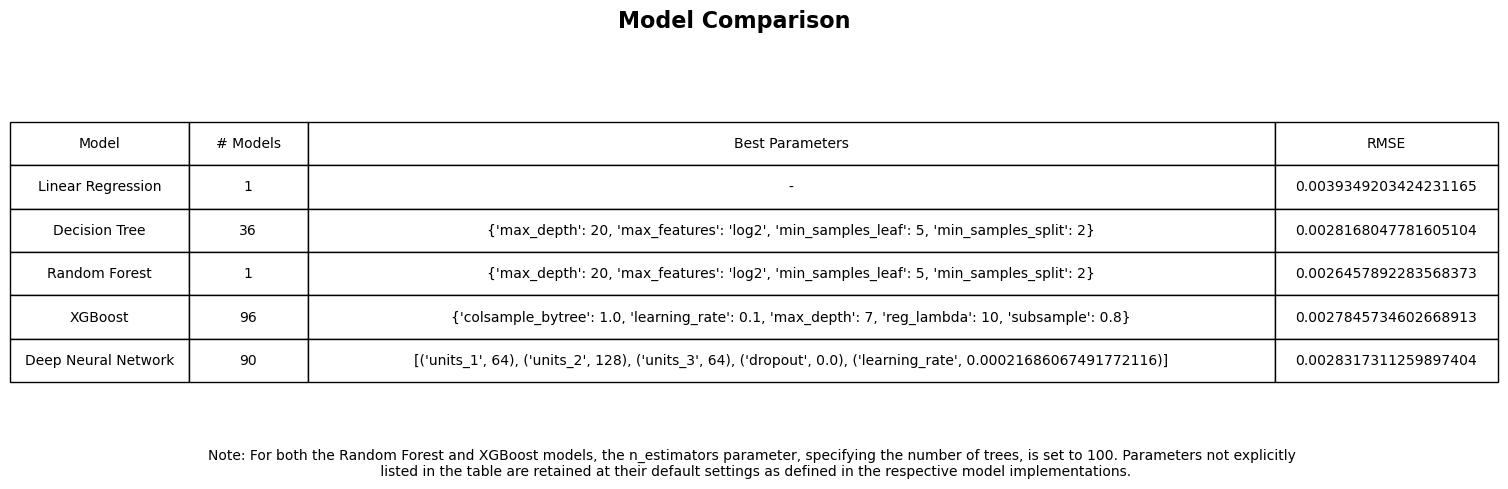

In [61]:
# Table
fig, ax = plt.subplots(figsize=(16, 5))  
ax.axis('tight')
ax.axis('off')
fig.suptitle('Model Comparison', fontsize=16, fontweight='bold')
colWidths = [0.12, 0.08, 0.65, 0.15]  
the_table = ax.table(cellText=df_results.values,
                     colLabels=df_results.columns,
                     loc='center',
                     cellLoc='center',
                     colWidths=colWidths)  
the_table.auto_set_font_size(False)
the_table.set_fontsize(10)
the_table.scale(1.2, 2.6) 
footnote_text = "Note: For both the Random Forest and XGBoost models, the n_estimators parameter, specifying the number of trees, is set to 100. Parameters not explicitly \n listed in the table are retained at their default settings as defined in the respective model implementations."
ax.text(0.5, -0.05, footnote_text, transform=ax.transAxes, ha='center', va='center', fontsize=10)
plt.show()

Among the five models evaluated, Random Forest delivers the best performance with the lowest RMSE of 0.00265, closely followed by XGBoost with an RMSE of 0.00278. The Decision Tree model ranks third with an RMSE of 0.00282, showing a result very similar to XGBoost. The Deep Neural Network (DNN) comes in fourth with a slightly higher RMSE of 0.00283. While these four models perform similarly, Linear Regression lags behind significantly, with an RMSE of 0.00393, indicating a much lower predictive accuracy compared to the others.